<a href="https://colab.research.google.com/github/Olivia-Feldman/DLStockPrectionCNNModel-/blob/Andrew/sources/stock_predictor_CNN%2BLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Default Imports

In [1]:
import requests
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Set Plot Stylizations

In [2]:
plt.rcParams.update({'font.size': 16})
plt.rcParams['figure.figsize'] = [12, 8]
plt.style.use('dark_background')

# Method for getting ticker data using Yahoo Finance API

This method downloads json data from the Yahoo! finance API and organizes it into a Pandas dataframe. The time frame of the data can start and end wherever the user wants it to. The start and end dates need to be a String in the form of a Unix Timestamp.

*Parameters:*

    ticker: String that specifies the trading ticker of the equity 
    startData: String that specifies the start time of the dataset. Formatted as a Unix Timestamp
    endData: String that specifies the start time of the dataset. Formatted as a Unix Timestamp

*Returns:*

    df: Pandas dataframe with timestamp, open, high, low, close, and volume of a ticker


*Resources:*
*   [Dataframe.shift](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.shift.html)



In [3]:
def getStockDataInRange(ticker: str, startDate: str, endDate: str):
    url = "https://query1.finance.yahoo.com/v8/finance/chart/" + ticker + "?period1=" + startDate + "&period2=" + endDate + "&useYfid=true&interval=1d&includePrePost=true&events=div%7Csplit%7Cearn&lang=en-US&region=US&crumb=Yo9B6QaqJUD&corsDomain=finance.yahoo.com"
    x = requests.get(url)
    jsonResponse = x.json()
    timestamps = jsonResponse["chart"]["result"][0]["timestamp"]
    open = jsonResponse["chart"]["result"][0]["indicators"]["quote"][0]["open"]
    high = jsonResponse["chart"]["result"][0]["indicators"]["quote"][0]["high"]
    low = jsonResponse["chart"]["result"][0]["indicators"]["quote"][0]["low"]
    close = jsonResponse["chart"]["result"][0]["indicators"]["quote"][0]["close"]
    volume = jsonResponse["chart"]["result"][0]["indicators"]["quote"][0]["volume"]

    datetimes = list(map(toDatetime, timestamps))

    data = {
        'timestamps' : datetimes,
        'open' : open,
        'high' : high,
        'low' : low,
        'close' : close,
        'volume' : volume
    }

    df = pd.DataFrame(data, columns=['timestamps', 'open', 'high', 'low', 'close', 'volume'])
    # Difference if based on 'close' price
    df['diff'] = df['close'].diff()
    df['change'] = df['diff'] / df['close'].shift(periods=1) * 100
    return df

def toDatetime(t):
    return datetime.fromtimestamp(t)

# Creating Dataframe with stock data

In [4]:
ticker = 'QQQ'
endDate = datetime.now().strftime('%s')
startDate = datetime(year=2009, month=1, day=1, hour=0, minute=0).strftime('%s')

df = getStockDataInRange(ticker=ticker, startDate=startDate, endDate=endDate)

# Function for plotting stock prices of data frame

In [5]:
def visualize_prices(df, x_values, y_values):
    ax = df.plot(x=x_values, y=[y_values], kind='line', title=ticker + ' prices in set range')
    vals = ax.get_yticks()
    ax.set_yticklabels(['${:1.2f}'.format(x) for x in vals])
    ax.xaxis.grid(True, which='minor', linestyle='-', linewidth=0.25)
    ax.set_axisbelow(True)
    ax.grid(linestyle='-', linewidth='0.5', color='gray')

    plt.show()

# Plotting QQQ open prices from January 1, 2009 to the current day using Unix Timestamps

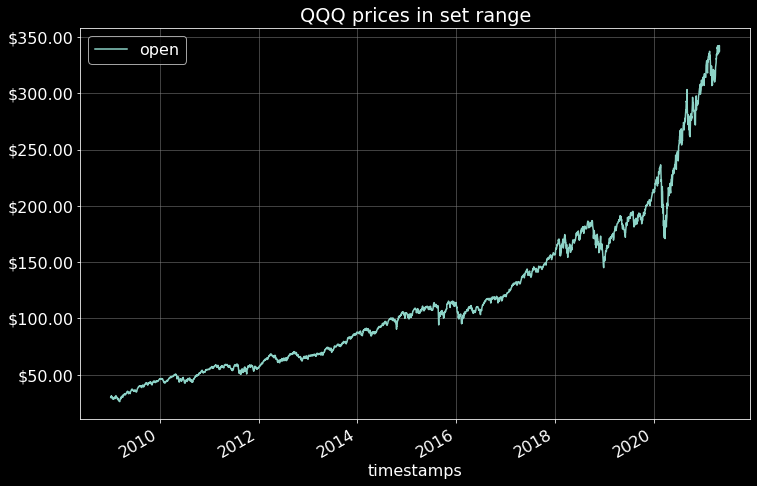

In [6]:
visualize_prices(df, 'timestamps', 'open')

# ax = df.plot(x='timestamps', y=['open'], kind='line', title=ticker + ' prices in set range')
# vals = ax.get_yticks()
# ax.set_yticklabels(['${:1.2f}'.format(x) for x in vals])
# ax.xaxis.grid(True, which='minor', linestyle='-', linewidth=0.25)
# ax.set_axisbelow(True)
# ax.grid(linestyle='-', linewidth='0.5', color='gray')

# plt.show()

# Showing Dataframe head

In [7]:
df.head()

,timestamps,open,high,low,close,volume,diff,change
0,2009-01-02 14:30:00,29.750000,31.129999,29.690001,31.030001,107891500,NaN,NaN
1,2009-01-05 14:30:00,30.830000,31.330000,30.590000,31.020000,91751900,-0.010000,-0.032228
2,2009-01-06 14:30:00,31.250000,31.629999,31.110001,31.330000,136791700,0.309999,0.999354
3,2009-01-07 14:30:00,30.730000,30.900000,30.190001,30.440001,133879800,-0.889999,-2.840726
4,2009-01-08 14:30:00,30.379999,30.799999,30.080000,30.760000,131926600,0.320000,1.051247


# Creating Training Data

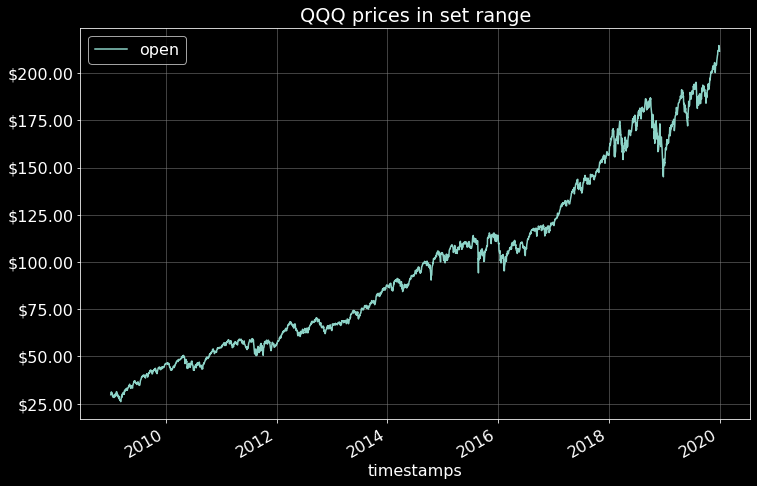

In [8]:
training_data = df[df['timestamps']<'2020-01-01'].copy()
visualize_prices(training_data, 'timestamps', 'open')

training_data = training_data.drop(['timestamps'], axis=1)
training_data = training_data.iloc[1:]    # Drops first row in dataframe
training_copy = training_data   # Need this to append last n row to testing data later
#training_data.head() 

# Creating Testing Data

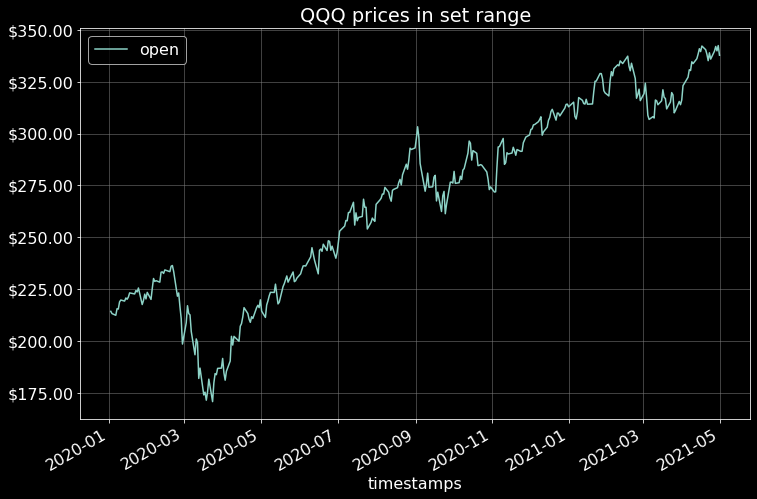

In [9]:
testing_data = df[df['timestamps']>='2020-01-01'].copy()
visualize_prices(testing_data, 'timestamps', 'open')

testing_data = testing_data.drop(['timestamps'], axis=1)
testing_data = testing_data.iloc[1:]    # Drops first row in dataframe
#testing_data.head() 

# Using z-score standardization

In [10]:
# from scipy import stats

# training_data = stats.zscore(training_data, axis=0, ddof=0, nan_policy='omit')

# n_bins = 50

# fig, axs = plt.subplots(2, 4, sharey=True, tight_layout=True)
# axs[0][0].hist(training_data[:, 0], bins=n_bins)
# axs[0][1].hist(training_data[:, 1], bins=n_bins)
# axs[0][2].hist(training_data[:, 2], bins=n_bins)
# axs[0][3].hist(training_data[:, 3], bins=n_bins)
# axs[1][0].hist(training_data[:, 4], bins=n_bins)
# axs[1][1].hist(training_data[:, 5], bins=n_bins)
# axs[1][2].hist(training_data[:, 6], bins=n_bins)

# Normalize data between 0 and 1

In [11]:
scaler = MinMaxScaler()
training_data = scaler.fit_transform(training_data)
training_data.shape

(2767, 7)

# Create data with time_step = 10

In [12]:
time_step = 10

x_train = []
y_train = []

for i in range(time_step, training_data.shape[0]):
    x_train.append(training_data[i-time_step:i])
    y_train.append(training_data[i, 0])

print(len(y_train))

2757


In [13]:
x_train, y_train = np.array(x_train), np.array(y_train)
x_train.shape, y_train.shape

((2757, 10, 7), (2757,))

# Import needed Keras components

In [14]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Conv1D, MaxPool1D, Activation

# Build CNN-LSTM model

In [15]:
filters = 32

model = Sequential([
    Conv1D(filters=filters, 
           kernel_size=1, 
           padding='same', 
           activation='tanh', 
           input_shape=(x_train.shape[1], x_train.shape[2])),
    MaxPool1D(pool_size=1, padding='same'),
    Activation('relu'),
    LSTM(units=64, 
         activation='relu', 
         #return_sequences=True, 
         input_shape=(x_train.shape[1], filters)),
    #Dropout(0.2),
    # LSTM(
    #     units=80, 
    #     activation='relu'),
    Dense(units=1) # Should I use a kernel initializer?
])

# Show summary of model

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 10, 32)            256       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 10, 32)            0         
_________________________________________________________________
activation (Activation)      (None, 10, 32)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                24832     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 25,153
Trainable params: 25,153
Non-trainable params: 0
_________________________________________________________________


# Compiling model

In [17]:
from tensorflow.keras import optimizers

learning_rate = 0.001

optimizer = optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, amsgrad=False)

model.compile(optimizer=optimizer, loss='mean_absolute_error')

# Fitting model

In [18]:
model.fit(x_train, y_train, epochs=100, batch_size=64)

Epoch 1/100
44/44 [==============================] - 2s 10ms/step - loss: 0.1496
Epoch 2/100
44/44 [==============================] - 0s 10ms/step - loss: 0.0093
Epoch 3/100
44/44 [==============================] - 0s 10ms/step - loss: 0.0046
Epoch 4/100
44/44 [==============================] - 0s 11ms/step - loss: 0.0038
Epoch 5/100
44/44 [==============================] - 0s 10ms/step - loss: 0.0055
Epoch 6/100
44/44 [==============================] - 0s 11ms/step - loss: 0.0058
Epoch 7/100
44/44 [==============================] - 0s 10ms/step - loss: 0.0037
Epoch 8/100
44/44 [==============================] - 0s 11ms/step - loss: 0.0043
Epoch 9/100
44/44 [==============================] - 0s 10ms/step - loss: 0.0043
Epoch 10/100
44/44 [==============================] - 0s 10ms/step - loss: 0.0035
Epoch 11/100
44/44 [==============================] - 0s 10ms/step - loss: 0.0033
Epoch 12/100
44/44 [==============================] - 0s 10ms/step - loss: 0.0032
Epoch 13/100
44/44 [=====

# Adding 

In [19]:
past_n_data_points = training_copy.tail(time_step)
past_df = past_n_data_points.append(testing_data, ignore_index=True)
past_df.head()

,open,high,low,close,volume,diff,change
0,209.539993,209.710007,209.039993,209.389999,15996100,0.119995,0.057340
1,209.570007,210.130005,209.330002,209.550003,15443300,0.160004,0.076414
2,209.639999,210.929993,209.619995,210.860001,17865900,1.309998,0.625148
3,211.860001,212.520004,211.270004,211.710007,27672600,0.850006,0.403114
4,212.000000,212.149994,211.630005,211.809998,23774700,0.099991,0.047230


In [20]:
inputs = scaler.transform(past_df)
inputs.shape

(344, 7)

In [21]:
x_test = []
y_test = []
for i in range(time_step, inputs.shape[0]):
    x_test.append(inputs[i-time_step:i])
    y_test.append(inputs[i, 0])

In [22]:
x_test, y_test = np.array(x_test), np.array(y_test)
x_test.shape, y_test.shape

((334, 10, 7), (334,))

In [23]:
y_pred = model.predict(x_test)
y_pred.shape

(334, 1)

In [24]:
y_pred = y_pred/scaler.scale_[0]
y_test = y_test/scaler.scale_[0]
y_pred.shape, y_test.shape

((334, 1), (334,))

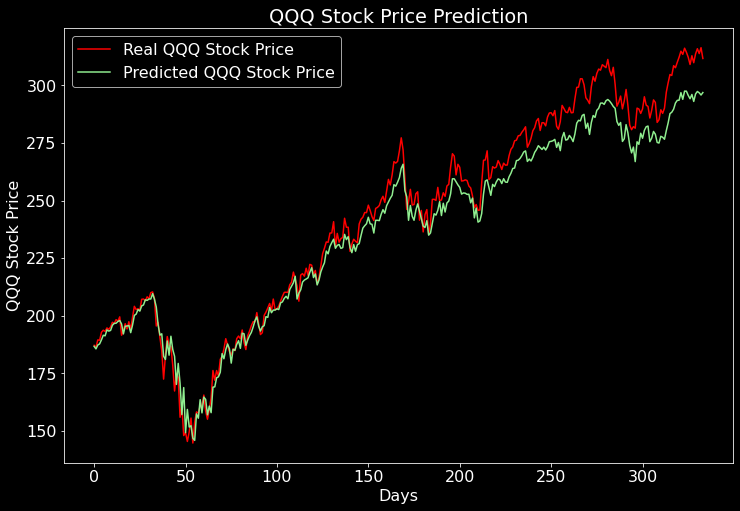

In [25]:
fig = plt.figure()
plt.plot(y_test, color='red', label='Real ' + ticker + ' Stock Price')
plt.plot(y_pred, color='lightgreen', label='Predicted ' + ticker + ' Stock Price')
plt.title(ticker + " Stock Price Prediction")
plt.xlabel('Days')
plt.ylabel(ticker + ' Stock Price')
plt.legend()
plt.show()

In [26]:
accuracy = 0

for i in range(1, y_pred.shape[0]):

    # Determining if the actual price increased
    actual_did_increase = y_test[i] > y_test[i-1]
    # Determining if the predicted price increased
    prediction_did_increase = y_pred[i] > y_pred[i-1]
    # If both the actual and predicted prices move in the same direction, 
    # then add 1 to the accuracy
    if (actual_did_increase == prediction_did_increase):
        accuracy = accuracy + 1


# Subtract 1 from y_pred.shape because we are staring at 1 instead of 0
print("Model accuracy: {:.3f}%".format(accuracy / (y_pred.shape[0] - 1) * 100)) 

Model accuracy: 74.474%


# Implementation of trading

In [48]:
model_variation = []
price_variation = []
buy_points = []
sell_points = []

maximum_trade_size = 3000.00
cash_on_hand = 10000.00
initial_value = cash_on_hand
number_of_shares = 0.00


for i in range(1, y_pred.shape[0]):
    # Current prediction price
    current_pred = y_pred[i][0]
    # Previous prediction price
    previous_pred = y_pred[i-1][0]
    # Current actual price
    current_actual= y_test[i]
    # Previous actual price
    previous_actual = y_test[i-1]

    change = ((current_pred - previous_pred) / previous_pred) * 100

    if (change >= 2.0):
        #print("Buy" + str(change) + "%")
        # The model is expecting the share price to increase
        # Use previous actual price to determine how many shares to buy
        maximum_allow_trade_size = min(maximum_trade_size, cash_on_hand)
        if ((cash_on_hand - maximum_trade_size) < 100):
            maximum_allow_trade_size = maximum_allow_trade_size - 100
        shares_to_buy = maximum_allow_trade_size / previous_actual
        number_of_shares = number_of_shares + shares_to_buy
        cash_on_hand = cash_on_hand - (shares_to_buy * previous_actual)
        if (cash_on_hand < 0):
            print("Fuck", cash_on_hand, i)
        buy_points.append(i-1)
    elif (change <= -3.0):
        #print("Sell: " + str(change) + "%")
        # The model is expecting the share price to decrease
        # Use previous price to determine how many shares to sell
        shares_to_sell = min(round(maximum_trade_size / previous_actual, 4), number_of_shares)
        number_of_shares = number_of_shares - shares_to_sell
        cash_on_hand = cash_on_hand + (shares_to_sell * previous_actual)
        sell_points.append(i-1)

    starting_price = y_test[1]

    price_variation.append((current_actual - starting_price) / starting_price * 100)
    model_variation.append((cash_on_hand + (number_of_shares * current_actual) - initial_value) / initial_value * 100)

end_price = y_test[-1]
share_value = end_price * number_of_shares

print("Cash left on hand: ${:.3f}".format(cash_on_hand))
print("Number of shares: {:.3f}".format(number_of_shares))
print("Value of shares: {:.3f}".format(share_value))
print("Total value: ${:.3f}".format(cash_on_hand + share_value))

print("Number of trades: {:.3f}".format(len(buy_points) + len(sell_points)))

Cash left on hand: $100.000
Number of shares: 58.748
Value of shares: 18306.589
Total value: $18406.589
Number of trades: 44.000


Text(0.5, 1.0, 'Model vs. Stock % Change Comparison')

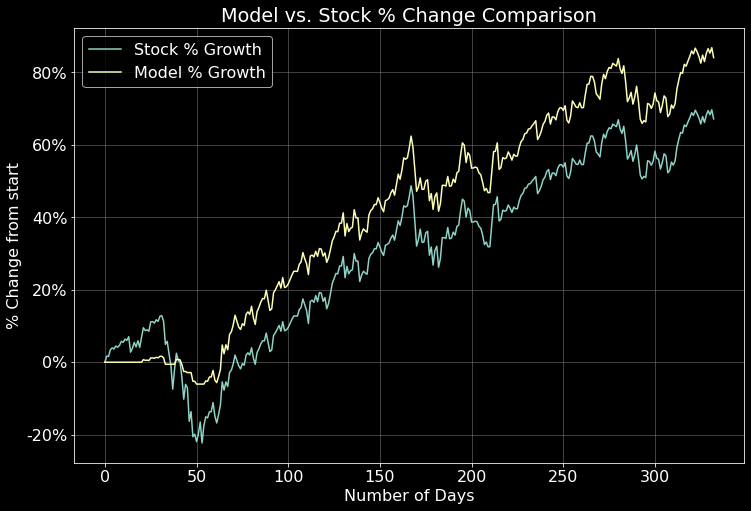

In [49]:
import matplotlib.ticker as mtick

fig, (ax) = plt.subplots(1, 1, sharex=True)

fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
yticks = mtick.FormatStrFormatter(fmt)
ax.yaxis.set_major_formatter(yticks)

ax.plot(price_variation, label='Stock % Growth')
ax.plot(model_variation, label='Model % Growth')

ax.xaxis.grid(True, which='minor', linestyle='-', linewidth=0.25)
ax.set_axisbelow(True)
ax.grid(linestyle='-', linewidth='0.5', color='gray')

ax.legend(loc='upper left')

ax.set_ylabel('% Change from start')
ax.set_xlabel('Number of Days')
ax.set_title('Model vs. Stock % Change Comparison')

In [50]:
import matplotlib.ticker as mtick

def marker_visualization(markers, title):
    fig, (ax) = plt.subplots(1, 1, sharex=True)

    fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
    yticks = mtick.FormatStrFormatter(fmt)
    ax.yaxis.set_major_formatter(yticks)

    ax.plot(price_variation, label='Stock % Growth', markevery=markers, marker='o', markerfacecolor='white')
    ax.plot(model_variation, label='Model % Growth')

    ax.xaxis.grid(True, which='minor', linestyle='-', linewidth=0.25)
    ax.set_axisbelow(True)
    ax.grid(linestyle='-', linewidth='0.5', color='gray')

    ax.legend(loc='upper left')

    ax.set_ylabel('% Change from start')
    ax.set_xlabel('Number of Days')
    ax.set_title(title)

# Model vs. Stock % Change with Buy Markers

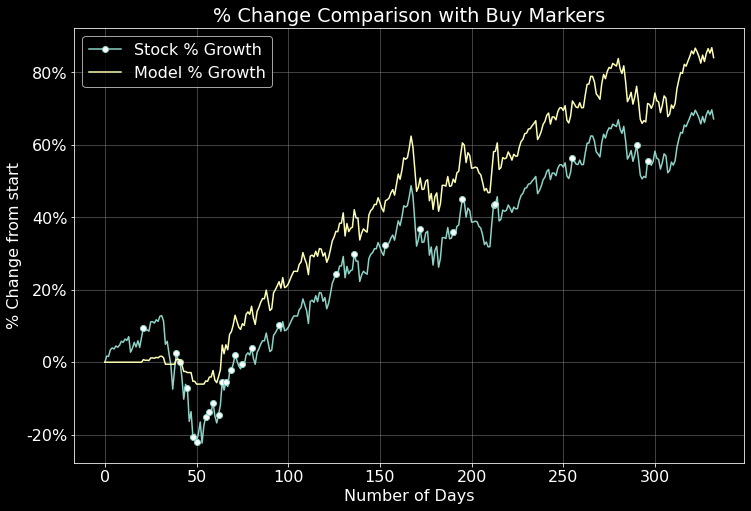

In [51]:
marker_visualization(markers=buy_points, title='% Change Comparison with Buy Markers')

Model vs. Stock % Change with Sell Markers

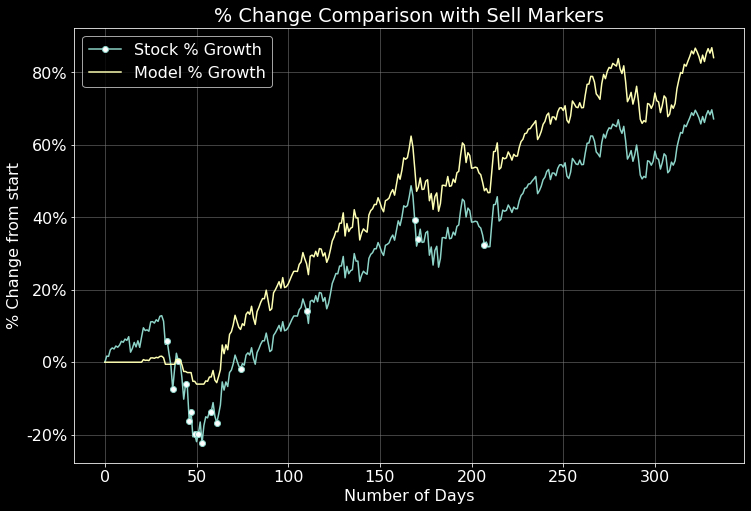

In [52]:
marker_visualization(markers=sell_points, title='% Change Comparison with Sell Markers')